## Import libraries

In [82]:
## Import libraries for machine learning and data processing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
## For random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
## Add libraries for SMOTE
from imblearn.over_sampling import SMOTE

## Load file

In [83]:
## import dataset
raw_feature_df_scaled = pd.read_csv('/Users/adityaponnada/Downloads/time_study_data/processed_features_v100.csv')
## Display the first few rows of the dataset
raw_feature_df_scaled.head()

,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,wake_day_part_24.0,wake_day_part_25.0,wake_day_part_26.0,wake_day_part_27.0,wake_day_part_28.0,wake_day_part_29.0,wake_day_part_30.0,wake_day_part_31.0,wake_day_part_32.0,wake_day_part_33.0
0,arrivejanitoruniformly@timestudy_com,1,1,NaN,NaN,0,0.000002,0.0,0.0,0.187031,...,0,0,0,0,0,0,0,0,0,0
1,arrivejanitoruniformly@timestudy_com,1,1,0.0,0.0,0,0.000002,0.0,0.0,0.180555,...,0,0,0,0,0,0,0,0,0,0
2,arrivejanitoruniformly@timestudy_com,1,1,NaN,NaN,0,0.000002,0.0,0.0,0.176050,...,0,0,0,0,0,0,0,0,0,0
3,arrivejanitoruniformly@timestudy_com,1,1,NaN,NaN,0,0.000002,0.0,0.0,0.172060,...,0,0,0,0,0,0,0,0,0,0
4,arrivejanitoruniformly@timestudy_com,1,1,NaN,NaN,0,0.000002,0.0,0.0,0.104721,...,0,0,0,0,0,0,0,0,0,0


## Impute missing data

In [64]:
def impute_missing_with_median(df):
    """
    Impute missing values in all columns of a DataFrame using the median strategy within each participant_id group, except for 'participant_id' and 'outcome'.
    If a group has all missing values for a column, fallback to the global median for that column.
    Returns a new DataFrame with imputed values.
    """
    skip_cols = ['participant_id', 'outcome']
    cols_to_impute = [col for col in df.columns if col not in skip_cols]
    df_result = df.copy()
    global_medians = df[cols_to_impute].median()
    def impute_group(group):
        group_medians = group.median()
        fill_values = group_medians.fillna(global_medians)
        return group.fillna(fill_values)
    # Only apply groupby to columns to impute, avoiding the warning
    imputed = df[cols_to_impute].groupby(df['participant_id'], group_keys=False).apply(impute_group)
    df_result[cols_to_impute] = imputed
    return df_result

# Example usage:
raw_feature_df_scaled = impute_missing_with_median(raw_feature_df_scaled)

## Split training and testing data

In [84]:
def split_train_test_by_time(df, id_col='participant_id', frac_train=0.10):
    """
    Splits the DataFrame so that for each participant_id, the first frac_train (default 10%) of rows are in the training set,
    and the remaining (tailing) rows are in the test set. Assumes data is sorted by time/order within each participant.
    Returns: train_df, test_df
    """
    train_list = []
    test_list = []
    for pid, group in df.groupby(id_col):
        n = len(group)
        split_idx = int(np.floor(frac_train * n))
        train_part = group.iloc[:split_idx]
        test_part = group.iloc[split_idx:]
        train_list.append(train_part)
        test_list.append(test_part)
    train_df = pd.concat(train_list).reset_index(drop=True)
    test_df = pd.concat(test_list).reset_index(drop=True)
    return train_df, test_df

# Example usage:
train_df, test_df = split_train_test_by_time(raw_feature_df_scaled)

## Median imputation on training data

In [ ]:
def impute_training_with_median(train_df, id_col='participant_id', outcome_col='outcome'):
    """
    Impute missing values in all feature columns of train_df using the median within each participant_id group.
    If a group has all missing values for a column, fallback to the global median for that column.
    Returns a new DataFrame with imputed values.
    """
    skip_cols = [id_col, outcome_col]
    cols_to_impute = [col for col in train_df.columns if col not in skip_cols]
    df_result = train_df.copy()
    global_medians = train_df[cols_to_impute].median()
    def impute_group(group):
        group_medians = group[cols_to_impute].median()
        fill_values = group_medians.fillna(global_medians)
        return group[cols_to_impute].fillna(fill_values)
    df_result[cols_to_impute] = train_df.groupby(id_col, group_keys=False).apply(impute_group)
    return df_result

# Example usage:
train_df = impute_training_with_median(train_df)

## Apply SMOTE to training data

In [ ]:

def apply_smote(train_df, outcome_col='outcome', id_col='participant_id', random_state=42):
    """
    Applies SMOTE to the training data to handle class imbalance. Returns resampled X and y as DataFrames/Series.
    """
    from imblearn.over_sampling import SMOTE
    feature_cols = [col for col in train_df.columns if col not in [outcome_col, id_col]]
    X_train = train_df[feature_cols]
    y_train = train_df[outcome_col]
    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    X_resampled = pd.DataFrame(X_resampled, columns=feature_cols)
    y_resampled = pd.Series(y_resampled, name=outcome_col)
    print('Original training set class distribution:')
    print(y_train.value_counts())
    print('Resampled training set class distribution:')
    print(y_resampled.value_counts())
    return X_resampled, y_resampled

# Example usage:
X_train_resampled, y_train_resampled = apply_smote(train_df)

Original training set class distribution:
outcome
1    85761
0    22924
Name: count, dtype: int64
Resampled training set class distribution:
outcome
1    85761
0    85761
Name: count, dtype: int64


## Train an individualized RandomForest classifier

In [68]:
def train_rf_per_participant(train_df, outcome_col='outcome', id_col='participant_id', random_state=42):
    """
    Trains a RandomForestClassifier (with class_weight='balanced') for each participant_id on their own training data.
    Returns a dictionary: participant_id -> trained classifier.
    """
    from sklearn.ensemble import RandomForestClassifier
    clfs = {}
    participant_ids = train_df[id_col].unique()
    for pid in participant_ids:
        user_df = train_df[train_df[id_col] == pid]
        feature_cols = [col for col in user_df.columns if col not in [outcome_col, id_col]]
        X = user_df[feature_cols]
        y = user_df[outcome_col]
        clf = RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=10, random_state=random_state)
        clf.fit(X, y)
        clfs[pid] = clf
    return clfs

# Example usage:
participant_clfs = train_rf_per_participant(train_df)

## Test on individual data

In [69]:
def evaluate_rf_per_participant(participant_clfs, test_df, outcome_col='outcome', id_col='participant_id'):
    """
    Evaluates each participant's RandomForest model on their own test data.
    Returns a DataFrame with accuracy, AUC, precision, recall, and F1 for each participant_id.
    """
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    results = []
    for pid, clf in participant_clfs.items():
        user_df = test_df[test_df[id_col] == pid]
        if user_df.empty:
            continue
        feature_cols = [col for col in user_df.columns if col not in [outcome_col, id_col]]
        X = user_df[feature_cols]
        y = user_df[outcome_col]
        if len(y.unique()) < 2:
            # Metrics like AUC are undefined if only one class is present
            auc = float('nan')
        else:
            if hasattr(clf, 'predict_proba'):
                y_proba = clf.predict_proba(X)[:, 1]
                auc = roc_auc_score(y, y_proba)
            else:
                auc = float('nan')
        y_pred = clf.predict(X)
        acc = accuracy_score(y, y_pred)
        prec = precision_score(y, y_pred, zero_division=0)
        rec = recall_score(y, y_pred, zero_division=0)
        f1 = f1_score(y, y_pred, zero_division=0)
        results.append({
            'participant_id': pid,
            'accuracy': acc,
            'auc': auc,
            'precision': prec,
            'recall': rec,
            'f1': f1
        })
    return pd.DataFrame(results)

# Example usage:
participant_results = evaluate_rf_per_participant(participant_clfs, test_df)

## ROC curve for each model against baseline

/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_21104/4121297969.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(participant_ids))


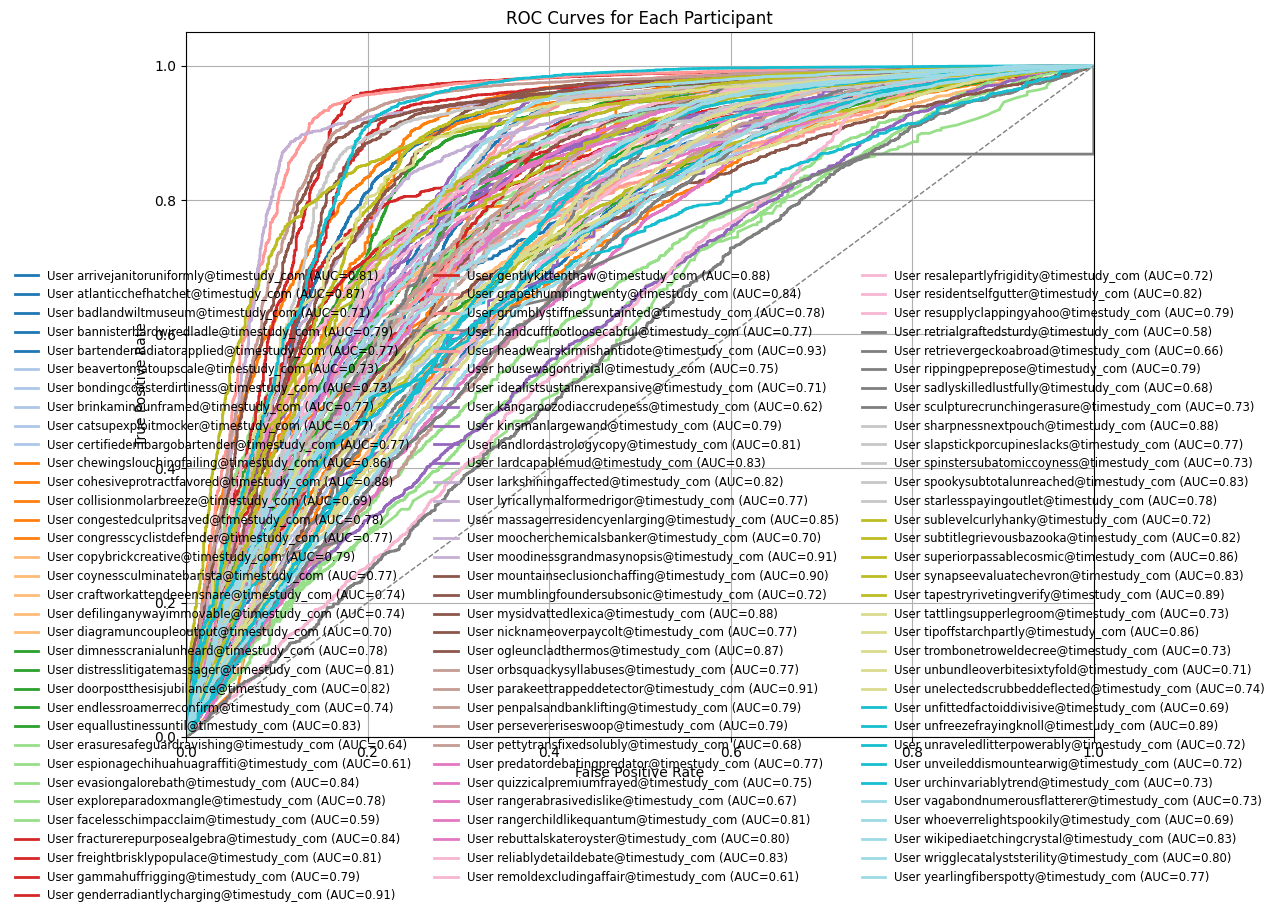

In [71]:
def plot_roc_curves_per_participant(participant_clfs, test_df, outcome_col='outcome', id_col='participant_id'):
    """
    Plots the ROC curve for each participant_id's model on their own test data, all in one plot with color-coded legend.
    """
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.cm as cm
    participant_ids = list(participant_clfs.keys())
    colors = cm.get_cmap('tab20', len(participant_ids))
    plt.figure(figsize=(10, 8))
    for idx, pid in enumerate(participant_ids):
        clf = participant_clfs[pid]
        user_df = test_df[test_df[id_col] == pid]
        if user_df.empty:
            continue
        feature_cols = [col for col in user_df.columns if col not in [outcome_col, id_col]]
        X = user_df[feature_cols]
        y = user_df[outcome_col]
        if len(y.unique()) < 2:
            continue  # ROC undefined if only one class present
        if hasattr(clf, 'predict_proba'):
            y_proba = clf.predict_proba(X)[:, 1]
        else:
            continue
        fpr, tpr, _ = roc_curve(y, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors(idx), lw=2, label=f'User {pid} (AUC={roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Each Participant')
    plt.grid(True)
    plt.tight_layout()
    plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), fontsize='small', ncol=3, frameon=False)
    plt.show()

# Example usage:
plot_roc_curves_per_participant(participant_clfs, test_df)

## View metrics for all participants

In [72]:
def print_participant_metrics(metrics_df):
    """
    Prints the DataFrame of model metrics for all participants, with columns as metrics and rows as participants.
    """
    print(metrics_df.to_string(index=False))

# Example usage:
print_participant_metrics(participant_results)

                          participant_id  accuracy      auc  precision   recall       f1
    arrivejanitoruniformly@timestudy_com  0.881262 0.809275   0.905208 0.956828 0.930302
       atlanticchefhatchet@timestudy_com  0.846076 0.870709   0.845321 0.941960 0.891028
         badlandwiltmuseum@timestudy_com  0.730693 0.712892   0.722784 0.931499 0.813975
   bannisterhardwiredladle@timestudy_com  0.829995 0.789673   0.843276 0.941963 0.889892
  bartenderradiatorapplied@timestudy_com  0.785697 0.768466   0.633871 0.366947 0.464814
       beavertomatoupscale@timestudy_com  0.833588 0.733800   0.844325 0.973430 0.904293
   bondingcoasterdirtiness@timestudy_com  0.676562 0.726018   0.690878 0.742813 0.715905
        brinkaminounframed@timestudy_com  0.745291 0.767535   0.784326 0.868349 0.824202
       catsupexploitmocker@timestudy_com  0.704539 0.766346   0.658734 0.646268 0.652442
 certifiedembargobartender@timestudy_com  0.807596 0.772679   0.846028 0.929913 0.885989
   chewingslouchingfa

## Visualize F1 distribution.

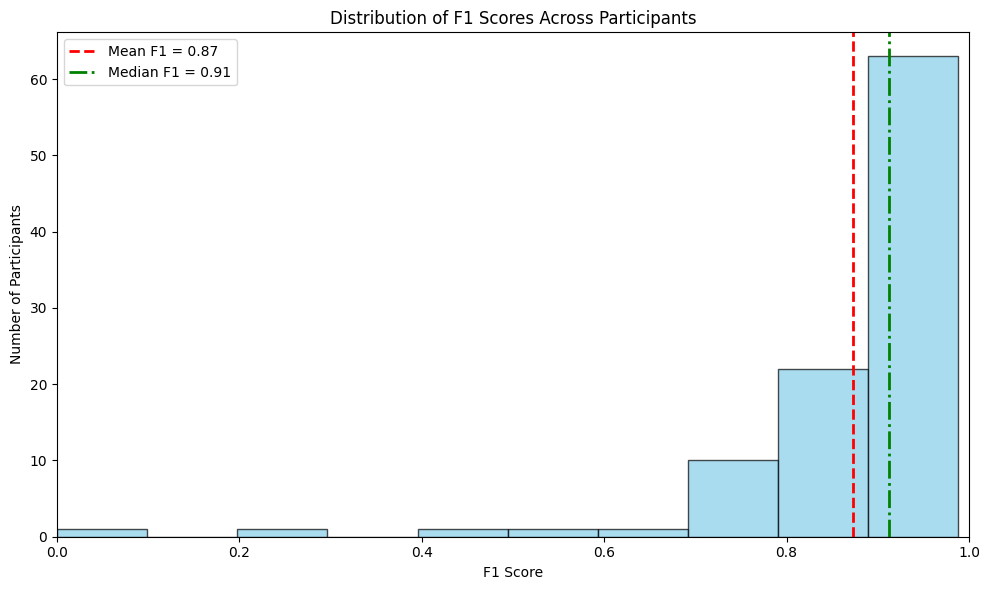

In [ ]:
def plot_f1_distribution(metrics_df):
    """
    Plots a histogram of F1 scores across all participant_ids, with mean and median lines labeled.
    """
    import matplotlib.pyplot as plt
    f1_scores = metrics_df['f1'].dropna()
    mean_f1 = f1_scores.mean()
    median_f1 = f1_scores.median()
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(f1_scores, bins=10, color='skyblue', edgecolor='black', alpha=0.7)
    # Mean and median lines
    ax.axvline(mean_f1, color='red', linestyle='--', linewidth=2, label=f'Mean F1 = {mean_f1:.2f}')
    ax.axvline(median_f1, color='green', linestyle='-.', linewidth=2, label=f'Median F1 = {median_f1:.2f}')
    ax.set_xlabel('F1 Score')
    ax.set_ylabel('Number of Participants')
    ax.set_title('Distribution of F1 Scores Across Participants')
    ax.set_xlim(0, 1)
    ax.legend()
    plt.tight_layout()
    plt.show()
    return fig

# Example usage:
f1_hist_fig = plot_f1_distribution(participant_results)

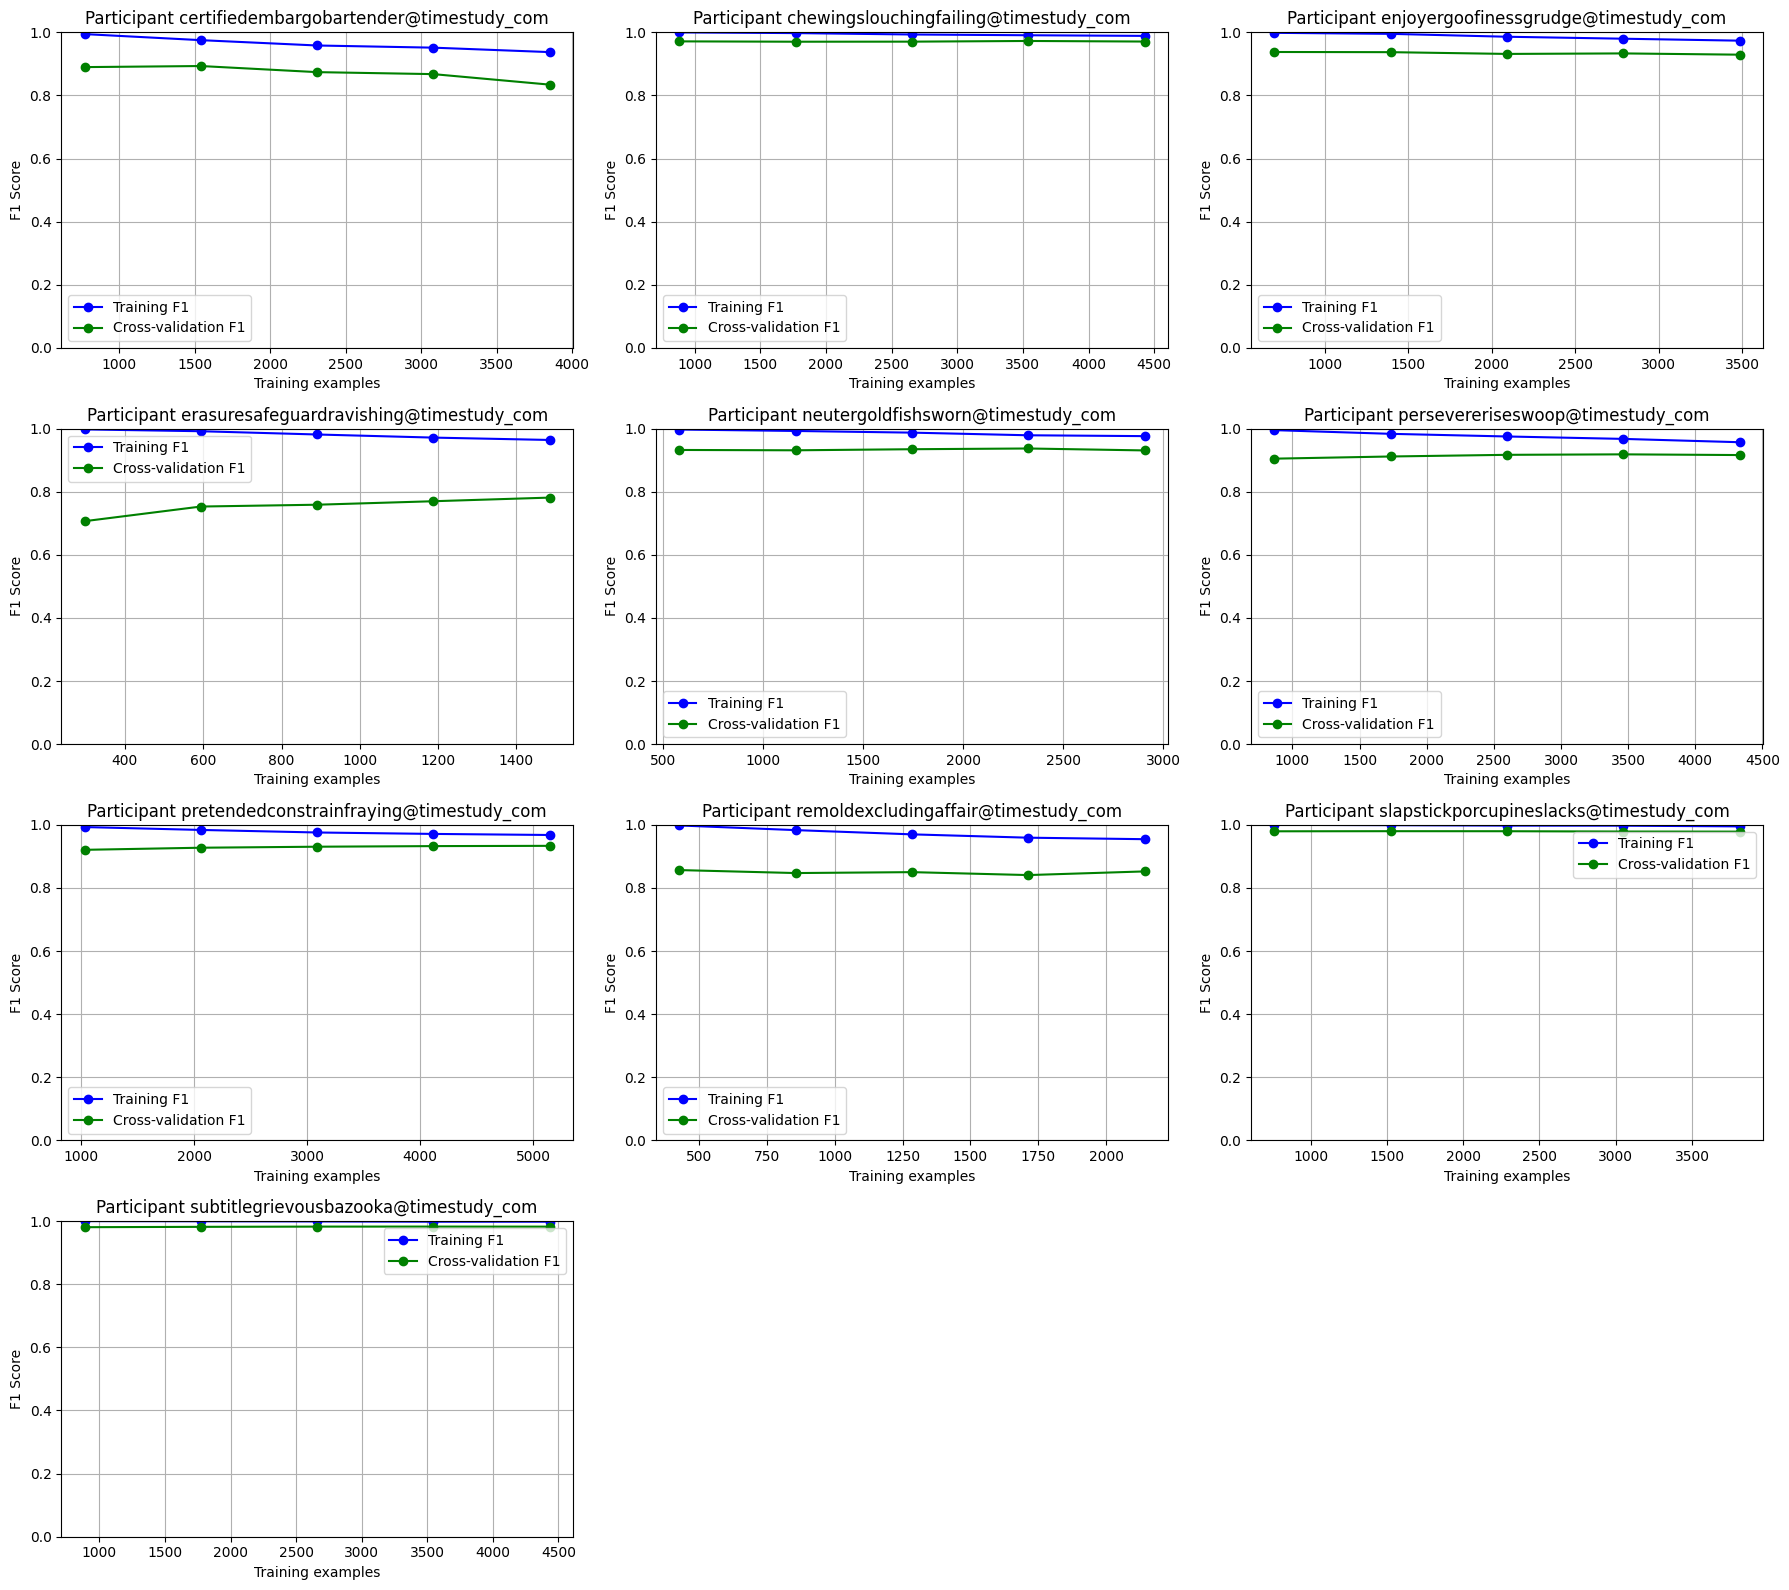

In [25]:
def plot_learning_curves_per_participant(train_df, outcome_col='outcome', id_col='participant_id', random_state=42):
    """
    Plots the learning curve (F1 score) for each participant_id using their own training data.
    """
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import learning_curve
    import matplotlib.pyplot as plt
    import numpy as np
    participant_ids = train_df[id_col].unique()
    n_participants = len(participant_ids)
    ncols = 3
    nrows = int(np.ceil(n_participants / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows), squeeze=False)
    for idx, pid in enumerate(participant_ids):
        user_df = train_df[train_df[id_col] == pid]
        feature_cols = [col for col in user_df.columns if col not in [outcome_col, id_col]]
        X = user_df[feature_cols]
        y = user_df[outcome_col]
        if len(np.unique(y)) < 2:
            continue  # skip if only one class
        clf = RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=10, random_state=random_state)
        train_sizes, train_scores, test_scores = learning_curve(
            clf, X, y, cv=3, scoring='f1', train_sizes=np.linspace(0.2, 1.0, 5), random_state=random_state)
        train_scores_mean = np.mean(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        ax = axes[idx // ncols, idx % ncols]
        ax.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training F1')
        ax.plot(train_sizes, test_scores_mean, 'o-', color='green', label='Cross-validation F1')
        ax.set_title(f'Participant {pid}')
        ax.set_xlabel('Training examples')
        ax.set_ylabel('F1 Score')
        ax.set_ylim(0, 1)
        ax.legend()
        ax.grid(True)
    # Hide any unused subplots
    for j in range(idx+1, nrows*ncols):
        fig.delaxes(axes[j // ncols, j % ncols])
    plt.tight_layout()
    plt.show()

# Example usage:
plot_learning_curves_per_participant(train_df)

In [75]:
# Print the number of training samples in train_df for all participants
participant_counts = train_df['participant_id'].value_counts().sort_index()
print('Number of training samples per participant:')
print(participant_counts)

Number of training samples per participant:
participant_id
arrivejanitoruniformly@timestudy_com       1084
atlanticchefhatchet@timestudy_com          1323
badlandwiltmuseum@timestudy_com            1225
bannisterhardwiredladle@timestudy_com      1275
bartenderradiatorapplied@timestudy_com      469
                                           ... 
vagabondnumerousflatterer@timestudy_com    1096
whoeverrelightspookily@timestudy_com        836
wikipediaetchingcrystal@timestudy_com      1289
wrigglecatalyststerility@timestudy_com     1245
yearlingfiberspotty@timestudy_com           918
Name: count, Length: 100, dtype: int64


In [76]:
# Compute and print mean and standard deviation of all metrics
if 'participant_results' in locals():
    metrics_mean = participant_results.mean(numeric_only=True)
    metrics_std = participant_results.std(numeric_only=True)
    print('Mean of metrics:')
    print(metrics_mean)
    print('\nStandard deviation of metrics:')
    print(metrics_std)
else:
    print('participant_results DataFrame not found. Please run the evaluation step first.')

Mean of metrics:
accuracy     0.834212
auc          0.775474
precision    0.840395
recall       0.914422
f1           0.873333
dtype: float64

Standard deviation of metrics:
accuracy     0.106002
auc          0.074658
precision    0.128903
recall       0.154284
f1           0.140986
dtype: float64


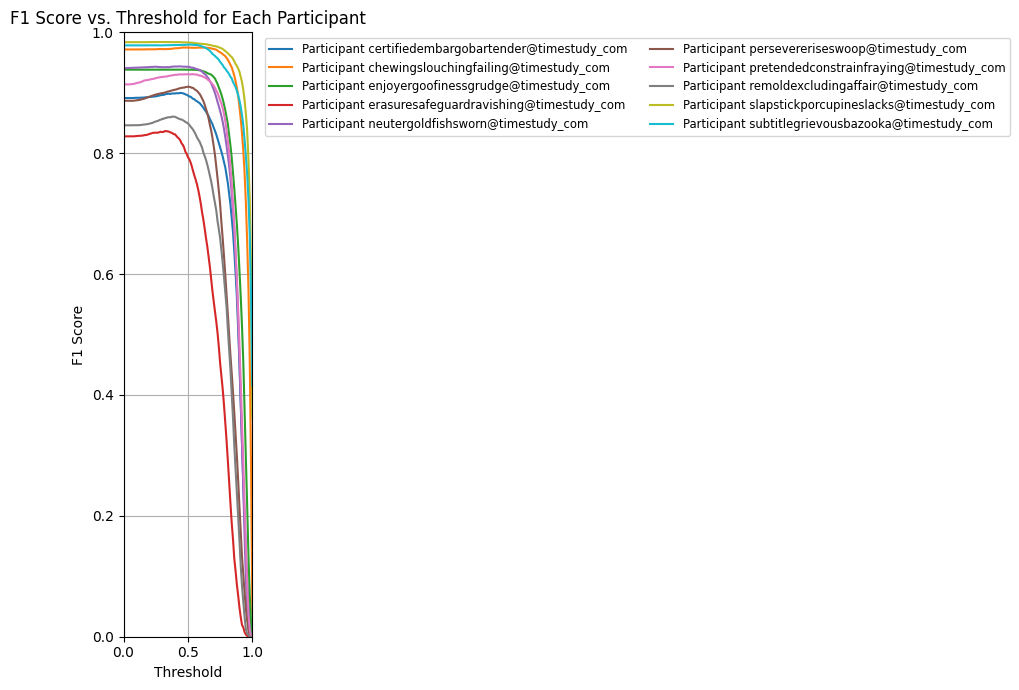

In [42]:
def plot_f1_vs_threshold_per_participant(participant_clfs, test_df, outcome_col='outcome', id_col='participant_id'):
    """
    Plots F1 score vs. threshold for each participant_id's model on their own test data, all on one plot.
    Each line represents a participant_id.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import f1_score
    thresholds = np.linspace(0, 1, 101)
    plt.figure(figsize=(10, 7))
    for pid, clf in participant_clfs.items():
        user_df = test_df[test_df[id_col] == pid]
        if user_df.empty:
            continue
        feature_cols = [col for col in user_df.columns if col not in [outcome_col, id_col]]
        X = user_df[feature_cols]
        y_true = user_df[outcome_col]
        if len(np.unique(y_true)) < 2 or not hasattr(clf, 'predict_proba'):
            continue
        y_proba = clf.predict_proba(X)[:, 1]
        f1s = []
        for thresh in thresholds:
            y_pred = (y_proba >= thresh).astype(int)
            f1 = f1_score(y_true, y_pred, zero_division=0)
            f1s.append(f1)
        plt.plot(thresholds, f1s, label=f'Participant {pid}')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs. Threshold for Each Participant')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend(fontsize='small', ncol=2, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_f1_vs_threshold_per_participant(participant_clfs, test_df)

In [ ]:
def rolling_window_cv_single_participant(participant_id, raw_feature_df_scaled, label_col='outcome', window_frac=0.1, step_frac=0.05, random_state=42):
    """
    Custom 5-fold rolling window cross-validation for a single participant_id:
    - First fold: first 10% of data for training, rest for testing
    - Subsequent folds: rolling window of 10% training data, incremented by 5% steps
    - Each training split undergoes SMOTE
    - RandomForestClassifier with class_weight='balanced'
    - Returns average accuracy, precision, recall, f1 for the participant
    """
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    from imblearn.over_sampling import SMOTE
    import numpy as np
    import pandas as pd

    df = raw_feature_df_scaled[raw_feature_df_scaled['participant_id'] == participant_id].sort_index()
    n_total = len(df)
    if n_total < 2:
        print(f"Not enough data for participant {participant_id}")
        return None
    feature_cols = [col for col in df.columns if col not in [label_col, 'participant_id']]
    window_size = int(np.floor(window_frac * n_total))
    step_size = int(np.floor(step_frac * n_total))
    accuracy_arr, precision_arr, recall_arr, f1_arr = [], [], [], []

    fold = 0
    train_start = 0
    train_end = window_size
    while train_end <= n_total and fold < 5:
        train_df = df.iloc[train_start:train_end]
        test_df = pd.concat([df.iloc[:train_start], df.iloc[train_end:]]).reset_index(drop=True)
        # SMOTE on training split
        X_train = train_df[feature_cols]
        y_train = train_df[label_col]
        if len(np.unique(y_train)) > 1:
            smote = SMOTE(random_state=random_state)
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        else:
            X_train_resampled, y_train_resampled = X_train.values, y_train.values
        X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=feature_cols)
        # Train RF
        clf = RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=10, random_state=random_state)
        clf.fit(X_train_resampled_df, y_train_resampled)
        # Test
        X_test = test_df[feature_cols]
        y_test = test_df[label_col]
        if len(y_test) == 0:
            fold += 1
            train_start += step_size
            train_end = train_start + window_size
            continue
        y_pred = clf.predict(X_test)
        accuracy_arr.append(accuracy_score(y_test, y_pred))
        precision_arr.append(precision_score(y_test, y_pred, zero_division=0))
        recall_arr.append(recall_score(y_test, y_pred, zero_division=0))
        f1_arr.append(f1_score(y_test, y_pred, zero_division=0))
        fold += 1
        train_start += step_size
        train_end = train_start + window_size
    mean_accuracy = np.mean(accuracy_arr) if accuracy_arr else np.nan
    mean_precision = np.mean(precision_arr) if precision_arr else np.nan
    mean_recall = np.mean(recall_arr) if recall_arr else np.nan
    mean_f1 = np.mean(f1_arr) if f1_arr else np.nan
    print(f"Participant {participant_id} - Accuracy: {mean_accuracy:.4f}, Precision: {mean_precision:.4f}, Recall: {mean_recall:.4f}, F1: {mean_f1:.4f}")
    return mean_accuracy, mean_precision, mean_recall, mean_f1

# Example usage:
# mean_accuracy, mean_precision, mean_recall, mean_f1 = rolling_window_cv_single_participant(123, raw_feature_df_scaled)

In [78]:
def rolling_window_cv_all_participants(raw_feature_df_scaled, label_col='outcome', window_frac=0.1, step_frac=0.05, random_state=42):
    """
    Runs rolling_window_cv_single_participant for each participant_id in raw_feature_df_scaled.
    Returns a DataFrame with participant_id, accuracy, precision, recall, f1.
    Handles SMOTE errors when there are not enough samples for resampling.
    """
    participant_ids = raw_feature_df_scaled['participant_id'].unique()
    results = []
    for pid in participant_ids:
        try:
            metrics = rolling_window_cv_single_participant(pid, raw_feature_df_scaled, label_col=label_col, window_frac=window_frac, step_frac=step_frac, random_state=random_state)
        except ValueError as e:
            print(f"Skipping participant {pid} due to error: {e}")
            metrics = None
        if metrics is not None:
            mean_accuracy, mean_precision, mean_recall, mean_f1 = metrics
            results.append({
                'participant_id': pid,
                'accuracy': mean_accuracy,
                'precision': mean_precision,
                'recall': mean_recall,
                'f1': mean_f1
            })
    import pandas as pd
    results_df = pd.DataFrame(results)
    print(results_df)
    return results_df

# Example usage:
participant_cv_results = rolling_window_cv_all_participants(raw_feature_df_scaled)

Participant arrivejanitoruniformly@timestudy_com - Accuracy: 0.8559, Precision: 0.9047, Recall: 0.9229, F1: 0.9135
Participant atlanticchefhatchet@timestudy_com - Accuracy: 0.8422, Precision: 0.8600, Recall: 0.9119, F1: 0.8852
Participant badlandwiltmuseum@timestudy_com - Accuracy: 0.7070, Precision: 0.7379, Recall: 0.8316, F1: 0.7814
Participant bannisterhardwiredladle@timestudy_com - Accuracy: 0.8153, Precision: 0.8423, Recall: 0.9192, F1: 0.8788
Participant bartenderradiatorapplied@timestudy_com - Accuracy: 0.7362, Precision: 0.5167, Recall: 0.4297, F1: 0.4581
Participant beavertomatoupscale@timestudy_com - Accuracy: 0.7923, Precision: 0.8683, Recall: 0.8754, F1: 0.8717
Participant bondingcoasterdirtiness@timestudy_com - Accuracy: 0.6619, Precision: 0.6838, Recall: 0.7194, F1: 0.6982
Participant brinkaminounframed@timestudy_com - Accuracy: 0.7124, Precision: 0.7856, Recall: 0.8061, F1: 0.7928
Participant catsupexploitmocker@timestudy_com - Accuracy: 0.6961, Precision: 0.6304, Recall

In [79]:
# Compute and print mean of all metrics in participant_cv_results
if 'participant_cv_results' in locals():
    metrics_mean = participant_cv_results[['accuracy', 'precision', 'recall', 'f1']].mean()
    print('Mean of metrics:')
    print(metrics_mean)
else:
    print('participant_cv_results DataFrame not found. Please run the cross-validation step first.')

Mean of metrics:
accuracy     0.814983
precision    0.857774
recall       0.870373
f1           0.862496
dtype: float64
